# [**Approximation explicite de la carte de caractéristiques pour les noyaux RBF**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/misc/plot_kernel_approximation.ipynb)<br/>([*Explicit feature map approximation for RBF kernels*](https://scikit-learn.org/stable/auto_examples/misc/plot_kernel_approximation.html))

[RBFSampler]: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
[Nystroem]: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html

Un exemple montrant l'approximation de la carte de caractéristiques d'un noyau RBF.

Il montre comment utiliser [**`RBFSampler`**][RBFSampler] et [**`Nystroem`**][Nystroem] pour approximer la carte de caractéristiques d'un noyau RBF pour la classification avec une SVM sur le jeu de données des chiffres. Les résultats en utilisant une SVM linéaire dans l'espace original, une SVM linéaire en utilisant les mappages approchés et en utilisant une SVM noyautée sont comparés. Les temps d'exécution et la précision pour différentes quantités de prélèvements Monte Carlo (dans le cas de [**`RBFSampler`**][RBFSampler], qui utilise des caractéristiques de Fourier aléatoires) et différents sous-ensembles de l'ensemble d'entraînement (pour [**`Nystroem`**][Nystroem]) pour le mappage approché sont montrés.

Veuillez noter que le jeu de données ici n'est pas assez grand pour montrer les avantages de l'approximation du noyau, car la SVM exacte est toujours raisonnablement rapide.

Échantillonner plus de dimensions conduit clairement à de meilleurs résultats de classification, mais cela a un coût plus élevé. Cela signifie qu'il existe un compromis entre temps d'exécution et précision, donné par le paramètre `n_components`. Veuillez noter que la résolution de la SVM linéaire et également de la SVM noyautée approchée peut être considérablement accélérée en utilisant la descente de gradient stochastique via [**`SGDClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). Ce n'est pas facilement possible pour le cas de la SVM noyautée.


# Packages Python et importations de jeu de données, chargement du jeu de données

In [1]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.decomposition import PCA

# The digits dataset
digits = datasets.load_digits(n_class=9)

# Graphiques de minutage et de précision

Pour appliquer un classificateur sur ces données, nous devons aplatir l'image, pour transformer les données en une matrice (échantillons, caractéristiques) :

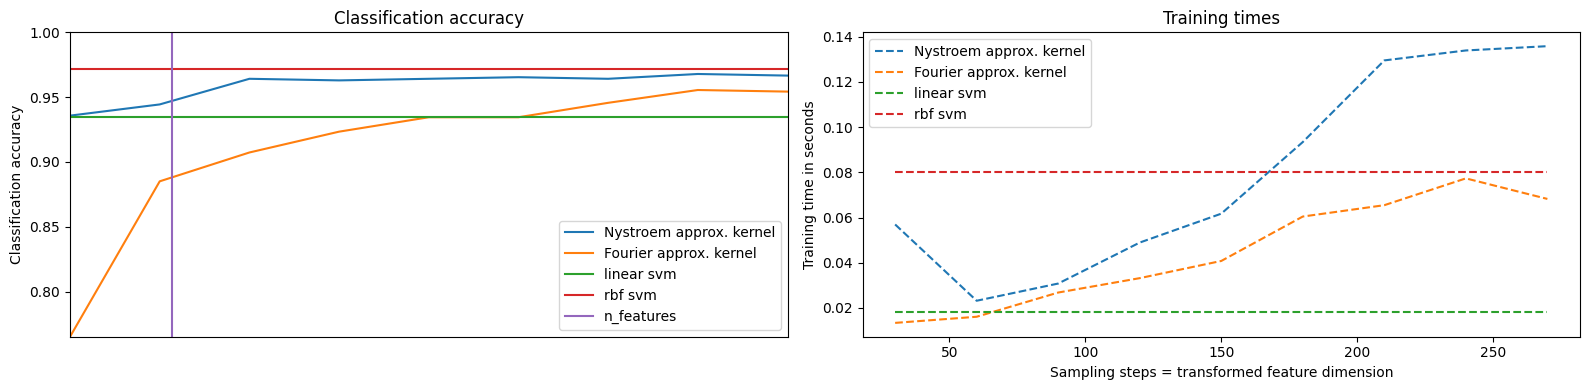

In [2]:
n_samples = len(digits.data)
data = digits.data / 16.0
data -= data.mean(axis=0)

# We learn the digits on the first half of the digits
data_train, targets_train = (data[: n_samples // 2], digits.target[: n_samples // 2])


# Now predict the value of the digit on the second half:
data_test, targets_test = (data[n_samples // 2 :], digits.target[n_samples // 2 :])
# data_test = scaler.transform(data_test)

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=0.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline(
    [("feature_map", feature_map_fourier), ("svm", svm.LinearSVC())]
)

nystroem_approx_svm = pipeline.Pipeline(
    [("feature_map", feature_map_nystroem), ("svm", svm.LinearSVC())]
)

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, "--", label="Nystroem approx. kernel")

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, "--", label="Fourier approx. kernel")

# horizontal lines for exact rbf and linear kernels:
accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_score, linear_svm_score],
    label="linear svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [linear_svm_time, linear_svm_time],
    "--",
    label="linear svm",
)

accuracy.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_score, kernel_svm_score],
    label="rbf svm",
)
timescale.plot(
    [sample_sizes[0], sample_sizes[-1]],
    [kernel_svm_time, kernel_svm_time],
    "--",
    label="rbf svm",
)

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc="best")
timescale.legend(loc="best")
plt.tight_layout()
plt.show()

# Surfaces de décision de l'SVM à noyau RBF et de l'SVM linéaire

[RBFSampler]: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
[Nystroem]: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html


Le deuxième graphique a visualisé les surfaces de décision de la SVM à noyau RBF et de la SVM linéaire avec des cartes de noyau approximatives. Le graphique montre les surfaces de décision des classificateurs projetées sur les deux premiers composants principaux des données. Cette visualisation doit être prise avec des pincettes car c'est simplement une tranche intéressante à travers la surface de décision en 64 dimensions. Notez en particulier qu'un point de données (représenté sous forme de point) ne doit pas nécessairement être classé dans la région où il se trouve, car il ne se trouvera pas sur le plan que les deux premiers composants principaux englobent. L'utilisation de [**`RBFSampler`**][RBFSampler] et de [**`Nystroem`**][Nystroem] est décrite en détail dans l'[**Approximation de noyau** (6.7)](https://scikit-learn.org/stable/modules/kernel_approximation.html#kernel-approximation).

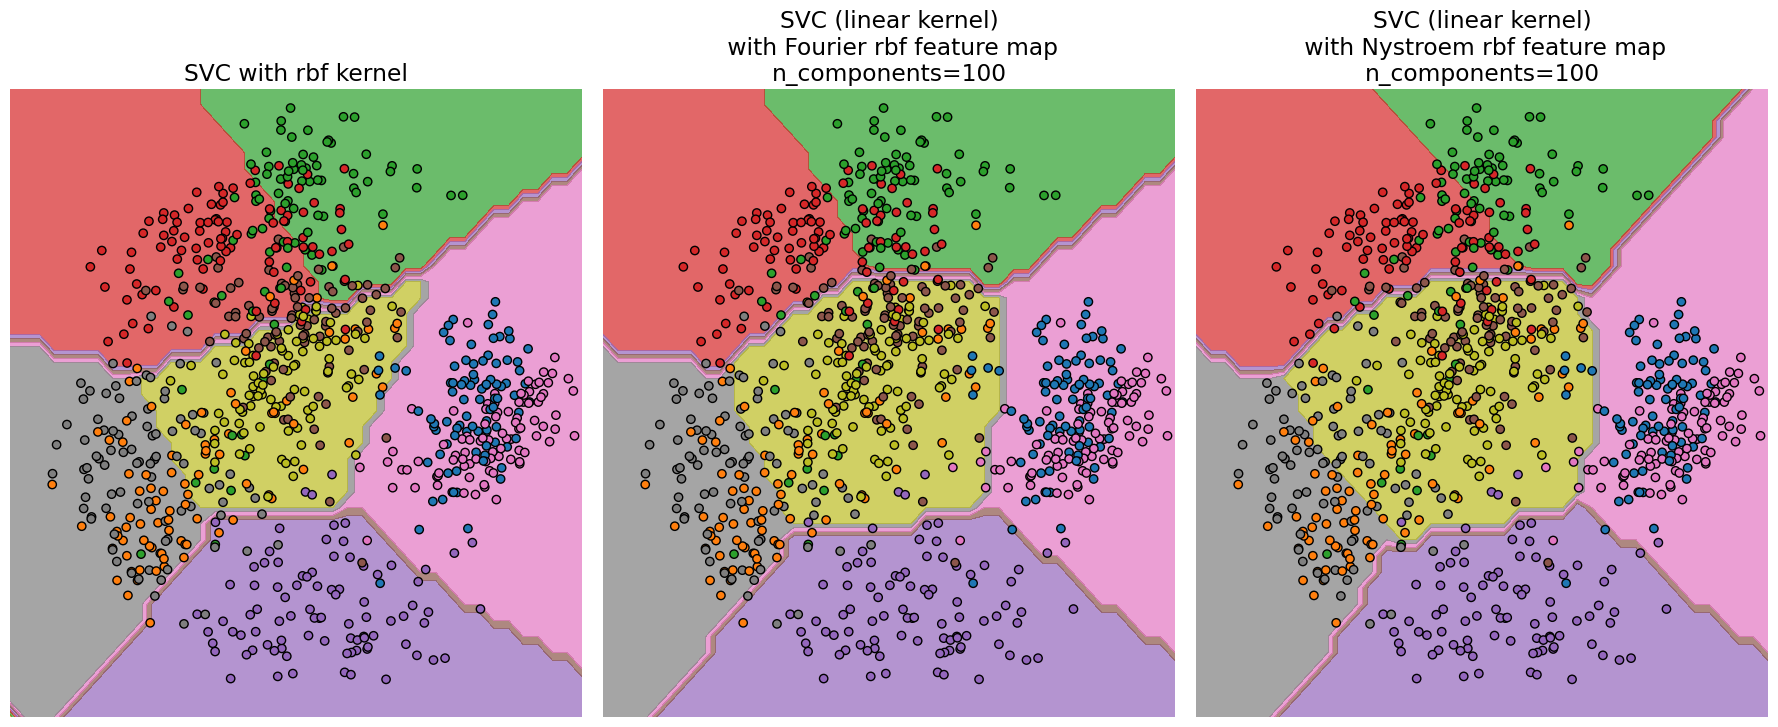

In [3]:
# visualize the decision surface, projected down to the first
# two principal components of the dataset
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = [
    "SVC with rbf kernel",
    "SVC (linear kernel)\n with Fourier rbf feature map\nn_components=100",
    "SVC (linear kernel)\n with Nystroem rbf feature map\nn_components=100",
]

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({"font.size": 14})
# predict and plot
for i, clf in enumerate((kernel_svm, nystroem_approx_svm, fourier_approx_svm)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    levels = np.arange(10)
    lv_eps = 0.01  # Adjust a mapping from calculated contour levels to color.
    plt.contourf(
        multiples,
        multiples,
        Z,
        levels=levels - lv_eps,
        cmap=plt.cm.tab10,
        vmin=0,
        vmax=10,
        alpha=0.7,
    )
    plt.axis("off")

    # Plot also the training points
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=targets_train,
        cmap=plt.cm.tab10,
        edgecolors=(0, 0, 0),
        vmin=0,
        vmax=10,
    )

    plt.title(titles[i])
plt.tight_layout()
plt.show()